### 1) Imports

In [1]:
#==========================================================
#                       Imports
#==========================================================
from __future__ import division

import os, sys, time
import h5py as hp
import numpy as np
import matplotlib.pyplot as plt
import pickle
import csv

import NAFFlib as pnf

# Added by Themis
import scipy
#sys.path.append('/Applications/anaconda/pkgs/')
#sys.path.append('/nfsbigdata1/tmastorigrp/src/')

from scipy.constants import m_p, c, e
from mpl_toolkits.mplot3d import Axes3D

from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.particles.generators import generate_Gaussian6DTwiss 
from PyHEADTAIL.trackers.detuners import Chromaticity, AmplitudeDetuning
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.simple_long_tracking import RFSystems, LinearMap
from PyHEADTAIL.monitors.monitors import BunchMonitor, SliceMonitor, ParticleMonitor
from PyHEADTAIL.feedback.transverse_damper import TransverseDamper
from PyHEADTAIL.impedances.wakes import CircularResonator, WakeTable, WakeField


sys.path.append('../../utils')
from coordinatesConversions import *
from cmpt_TuneSpreads import *

%matplotlib inline

PyHEADTAIL v1.13.5


--> Use the longitudinal_tracking module instead.



/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/PyHEADTAIL/trackers/simple_long_tracking.py:10: DeprecationWarning: 

*** DEPRECATED: "simple_long_tracking" will be replaced in a future PyHEADTAIL release!
  simple_long_tracking()


In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (8, 7),
          'axes.labelsize': 25,
          'axes.titlesize': 21,
          'xtick.labelsize': 23,
          'ytick.labelsize': 23,
          'image.cmap': 'jet',
          'lines.linewidth': 2,
          'lines.markersize': 7,
          'font.family': 'sans-serif'}


plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
plt.close('all')

### 2) Variables we change

In [4]:
#==========================================================
#               Variables We Change
#==========================================================
n_turns = 500           #number of cycles to run the simulation for. 500 turns are enough for the tune estimation using NAFFlib
decTurns = 1           #how often to record data

Q_y = 26.18                #How many times the particles oscillate in phase space each turn 
Q_x = 26.13                          # Will need it to be 16.25 IF CC feedback is used
                            # For this version of PyHEADTAIL Q_x should be an array

ampGain = 0               #strength of amplitude feedback (usually between 0 and 0.15)
phaseGain = 0             #strength of phase feedback (usually between 0 and 0.15)

filename = 'file'      #Where the data for the run is saved

numDelay = 1                #Turns of delay between measuring and acting with the feedback system
                            #Make sure to adjust Q_x if adjusting numDelay

ampNoiseOn = 0              #Turns on the amplitude noise - 0 is off, 1 is on
phaseNoiseOn = 0            #Turns on the phase noise - 0 is off, 1 is on
stdAmpNoise = 1e-8          #Size of amplitude noise (1e-8 for ~22nm/s at 0 ampGain)
stdPhaseNoise = 1e-8      #Size of phase noise (1e-8 for ~24nm/s at 0 phaseGain)

damperOn = 0                #Turns on the damper - 0 is off, 1 is on
dampingrate_x = 50          #Strength of the damper (note it must be turned on further down in the code) 
                            #(40 is the "standard" value)

wakefieldOn = 0         # Turns on the wakefields
    
measNoiseOn = 0             #Turns on the measurement noise - 0 is off, 1 is on
stdMeasNoise = 1000e-9       #standard deviation of measurement noise

### 3) Variables we don't change

In [31]:
#==========================================================
#           Variables We (Usually) Do Not Change
#==========================================================

gamma = 287.8
p0 = m_p*c*np.sqrt(gamma**2 - 1)
beta = np.sqrt(1 - 1/gamma**2)
circumference = 6911.5623
frev = 299792458/circumference


# PARAMETERS FOR TRANSVERSE MAP
# =====================
n_segments = 1
s = np.arange(0, n_segments+1)*circumference/n_segments
# optics at CC2
alpha_x = 0 * np.ones(n_segments)  # -0.9120242128
beta_x = 30.31164764 * np.ones(n_segments)
D_x = 0 * np.ones(n_segments) # -0.4954033073
alpha_y = 0 * np.ones(n_segments)  # 1.862209583
beta_y = 73.81671646 * np.ones(n_segments)
D_y = 0 * np.ones(n_segments)


#i_wake         = 1
# beta_x[i_wake] = 54.65 #### (for Q20)
# beta_y[i_wake] = 54.51 #### (for Q20)
#beta_x[i_wake] = 42.0941 #### (for Q26)
#beta_y[i_wake] = 42.0137 #### (for Q26)



Q_x, Q_y = 26.13, 26.18
Qp_x, Qp_y = 0.5, 0.5 #10

# detuning coefficients in (1/m)
app_x = -4000.0 #153.8183853  #2.4705e-15 #4e-11
app_xy = 4000 # -416.0175086  #-0*2.25e-11
app_y = 4000.0 #-50.03699877 #-7.31-14 #0*3e-11

# PARAMETERS FOR LONGITUDINAL MAP
# =======================
alpha = 1.9e-3
Q_s = 0.0051
h1, h2 = 4620, 9240
V1, V2 = 5.008e6, 0e6
dphi1, dphi2 = 0, np.pi
p_increment = 0 * e/c * circumference/(beta*c)

# CREATE DAMPER
# =============
dampingrate_y = 10 #40
damper = TransverseDamper(dampingrate_x, dampingrate_y)

# CREATE BEAM
# ===========
macroparticlenumber = int(900) # at least 5e5 particles are needed in the presence of the wakefields

charge = e
mass = m_p

R = circumference/(2*np.pi)
eta = alpha-1/gamma**2
beta_z = np.abs(eta)*R/Q_s


epsn_x = 2e-6
epsn_y = 2e-6     
epsn_z    = 2.5
sigma_z   = 0.155 #2*0.0755

sigma_x = np.sqrt(epsn_x/(beta*gamma) * beta_x[0])
sigma_xp = sigma_x/beta_x[0]
sigma_y = np.sqrt(epsn_y/(beta*gamma) * beta_y[0])
sigma_yp = sigma_y/beta_y[0]
sigma_dp = sigma_z/beta_z
epsn_z = 4*np.pi * p0/e * sigma_z*sigma_dp

intensity = 3.5e10

# GENERATE BUNCH - grid equally spaced in Jx and Jy up to 3 sigma
# ==================

bunch = generate_Gaussian6DTwiss(macroparticlenumber, intensity, charge, mass, circumference, gamma, alpha_x[0], alpha_y[0], beta_x[0], beta_y[0], beta_z, epsn_x, epsn_y, epsn_z)

# Switch to action angle coordinates
x_n, xp_n = cmpt_normalised_coordinates(bunch.x, bunch.xp, beta_x[0], alpha_x[0])
y_n, yp_n = cmpt_normalised_coordinates(bunch.y, bunch.yp, beta_y[0], alpha_y[0])


Jx, Jy = cmpt_actions(x_n, xp_n), cmpt_actions(y_n, yp_n)
Jx_std, Jy_std = np.std(Jx), np.std(Jy)


print(3*Jx_std, 3*Jy_std)
# Create the initial condition
steps = int(np.sqrt(macroparticlenumber))
J_min = 10**(-12)
Jx_max = 3*Jx_std
Jy_max = 3*Jy_std

Jx = np.linspace(J_min, Jx_max, steps)
Jy = np.linspace(J_min, Jy_max, steps)

# Go back to cartesian coordinates. For px and py =0 
x = np.sqrt(Jx*beta_x[0]*2)
y = np.sqrt(Jy*beta_y[0]*2)

# meshgrid
xx, yy = np.meshgrid(x, y)


bunch.x = xx.flatten()
bunch.y = yy.flatten()


bunch.xp = 0 * np.ones(macroparticlenumber)
bunch.yp = 0 * np.ones(macroparticlenumber)
bunch.z = 0 * np.ones(macroparticlenumber)
bunch.dp = 0 * np.ones(macroparticlenumber)


afile = open('bunch', 'wb')
pickle.dump(bunch, afile)
afile.close()


'''
# SLICER FOR WAKEFIELDS
# ============
n_slices = 500 # 500
slicer_for_wakefields = UniformBinSlicer(n_slices, z_cuts=(-3.*sigma_z, 3.*sigma_z))#,circumference=circumference, h_bunch=h1)

# WAKEFIELD
# ==========
n_turns_wake = 1 # for the moment we consider that the wakefield decays after 1 turn
wakefile1 = ('newkickers_Q26_2018_modified.txt')
wakefile2 = ('wall_Q26_2018.txt')

ww1 = WakeTable(wakefile1, ['time', 'dipole_x', 'dipole_y', 'quadrupole_x', 'quadrupole_y'], n_turns_wake=n_turns_wake)
ww2 = WakeTable(wakefile2, ['time', 'dipole_x', 'dipole_y', 'quadrupole_x', 'quadrupole_y'], n_turns_wake=n_turns_wake)
replace quadr or dipole with just 0 

wake_field_kicker = WakeField(slicer_for_wakefields, ww1)#, beta_x=beta_x, beta_y=beta_y)
wake_field_wall = WakeField(slicer_for_wakefields, ww2)#, beta_x=beta_x, beta_y=beta_y)

'''

Dampers active
2.1297565647718958e-08 2.169221937566917e-08


"\n# SLICER FOR WAKEFIELDS\n# ============\nn_slices = 500 # 500\nslicer_for_wakefields = UniformBinSlicer(n_slices, z_cuts=(-3.*sigma_z, 3.*sigma_z))#,circumference=circumference, h_bunch=h1)\n\n# WAKEFIELD\n# ==========\nn_turns_wake = 1 # for the moment we consider that the wakefield decays after 1 turn\nwakefile1 = ('newkickers_Q26_2018_modified.txt')\nwakefile2 = ('wall_Q26_2018.txt')\n\nww1 = WakeTable(wakefile1, ['time', 'dipole_x', 'dipole_y', 'quadrupole_x', 'quadrupole_y'], n_turns_wake=n_turns_wake)\nww2 = WakeTable(wakefile2, ['time', 'dipole_x', 'dipole_y', 'quadrupole_x', 'quadrupole_y'], n_turns_wake=n_turns_wake)\nreplace quadr or dipole with just 0 \n\nwake_field_kicker = WakeField(slicer_for_wakefields, ww1)#, beta_x=beta_x, beta_y=beta_y)\nwake_field_wall = WakeField(slicer_for_wakefields, ww2)#, beta_x=beta_x, beta_y=beta_y)\n\n"

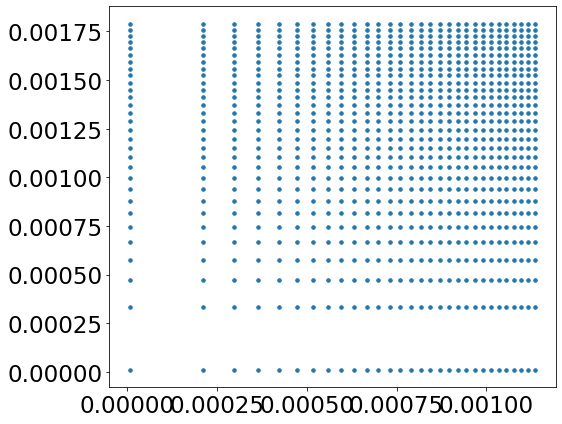

In [32]:
plt.plot(bunch.x, bunch.y, '.')

### 4) Create transverse and longitudinal map

In [33]:
scale_factor = 2*bunch.p0  # scale the detuning coefficients in pyheadtail units
transverse_map = TransverseMap(s, alpha_x, beta_x, D_x, alpha_y, beta_y, D_y, Q_x, Q_y,
    [Chromaticity(Qp_x, Qp_y),
    AmplitudeDetuning(app_x*scale_factor, app_y*scale_factor, app_xy*scale_factor)])

longitudinal_map = LinearMap([alpha], circumference, Q_s)

### 5) Set up the acclerator

In [34]:
if ampNoiseOn == 1:
    ampKicks = np.random.normal(0, stdAmpNoise, n_turns)
else:
    ampKicks = np.zeros(n_turns)
if phaseNoiseOn == 1:
    phaseKicks = np.random.normal(0, stdPhaseNoise, n_turns)
else:
    phaseKicks = np.zeros(n_turns)
if measNoiseOn == 1:
    noise = np.random.normal(0, stdMeasNoise, n_turns)# / beta_x[0] #Remove beta_x[0] when measuring in x
else:
    noise = np.zeros(n_turns)

delayAmp = np.zeros(numDelay + 1)
delayPhase = np.zeros(numDelay + 1)

t0 = time.clock()

one_turn_map = []
for i, segment in enumerate(transverse_map):
    one_turn_map.append(segment)
    #if wakefieldOn:
    #    if i+1 == i_wake:
    #        one_turn_map.append(wake_field_kicker)
    #        one_turn_map.append(wake_field_wall)
one_turn_map.append(longitudinal_map)

n_damped_turns = int(n_turns/decTurns) # The total number of turns at which the data are damped.
                       # We want this number as an integer, so it can be used in the next functions. 


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


### 6) Start tracking

In [35]:
X = {}
Y = {}
meanX = np.zeros(n_damped_turns)
meanY = np.zeros(n_damped_turns)
    

file2 = open(f'bunch', 'rb')
bunch = pickle.load(file2)
file2.close()

for i in range(n_turns):

    # Crab cavity
    Vcc = 1e6
    p_cc = Vcc/(gamma*.938e9)  # Vo/Eb
    #bunch.xp += (i/n_turns)*p_cc*np.sin(2*np.pi*400e6/(bunch.beta*c)*bunch.z)  

    # Gaussian Amplitude noise
    #bunch.xp += ampKicks[i]*np.sin(2*np.pi*400e6/(bunch.beta*c)*bunch.z)
    bunch.yp += ampKicks[i]*np.sin(2*np.pi*400e6/(bunch.beta*c)*bunch.z)

    # Gaussian Phase noise
    #bunch.xp += phaseKicks[i]*np.cos(2*np.pi*400e6/(bunch.beta*c)*bunch.z)
    bunch.yp += phaseKicks[i]*np.cos(2*np.pi*400e6/(bunch.beta*c)*bunch.z)

    #These next two lines actually "run" the simulation - the computationally heavy part
    for m in one_turn_map:
        m.track(bunch)
            
    '''
    negavg = np.mean(bunch.x[bunch.z < 0.0])
    posavg = np.mean(bunch.x[bunch.z > 0.0])

    #Amplitude Correction
    posCorr = (posavg-negavg)/2
    posCorr = posCorr + noise[i]
    momCorr = (ampGain)*posCorr/beta_x[0]
    delayAmp[0:-1] = delayAmp[1:]
    delayAmp[numDelay] = momCorr
    #bunch.xp += delayAmp[0]*np.sin(2*np.pi*400e6/(bunch.beta*c)*bunch.z)

    #Phase Correction
    posCorr = (posavg+negavg)/2
    posCorr = posCorr + noise[i]
    momCorr = (phaseGain)*posCorr/beta_x[0]
    delayPhase[0:-1] = delayPhase[1:]
    delayPhase[numDelay] = momCorr
    #bunch.xp += delayPhase[0]*np.cos(2*np.pi*400e6/(bunch.beta*c)*bunch.z)
    '''
        
    if i%decTurns is  0:
        j = int(i/decTurns)
        X[f'turn {j}'] = bunch.x
        Y[f'turn {j}'] = bunch.y
        meanX[j] = np.mean(bunch.x)
        meanY[j] = np.mean(bunch.y)
dataExport = [X, Y, meanX, meanY]

f = open(filename+f'.txt', 'w')

with f:
    out = csv.writer(f, delimiter=',')
    out.writerows(zip(*dataExport))

print('--> Done.')

print("Simulation time in seconds: " + str(time.clock() - t0))

--> Done.
Simulation time in seconds: 0.1949620000000003


/home/natalia/anaconda3/envs/run_pyheadtail/lib/python3.7/site-packages/ipykernel_launcher.py:67: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


### Compute coherent tune shift

In [36]:
Qx_coherent = pnf.get_tune(meanX)
Qy_coherent = pnf.get_tune(meanY)
print(Qx_coherent, Qy_coherent)

0.12998258929312612 0.18019131043741887


### Compute incoherent tune shift from tracking

In [37]:
Qx_incoherent_tracking = []
Qy_incoherent_tracking = []

for particle in range(macroparticlenumber):
    x_signal = []
    y_signal = []
    for turn in range(n_turns):
        x_signal.append(X[f'turn {turn}'][particle])
        y_signal.append(Y[f'turn {turn}'][particle])

   
    Qx_incoherent_tracking.append(pnf.get_tune(np.array(x_signal)))
    Qy_incoherent_tracking.append(pnf.get_tune(np.array(y_signal)))



### Compute incoherent tune shift analytically

In [38]:
file2 = open(f'bunch', 'rb')
bunch = pickle.load(file2)
file2.close()

# Switch to action angle coordinates
x_n, xp_n = cmpt_normalised_coordinates(bunch.x, bunch.xp, beta_x[0], alpha_x[0])
y_n, yp_n = cmpt_normalised_coordinates(bunch.y, bunch.yp, beta_y[0], alpha_y[0])


Jx, Jy = cmpt_actions(x_n, xp_n), cmpt_actions(y_n, yp_n)

In [39]:
Qx_incoherent_analytical = amplitude_detuning_x(Jx, Jy, app_x, app_xy)
Qy_incoherent_analytical = amplitude_detuning_y(Jx, Jy, app_y, app_xy)

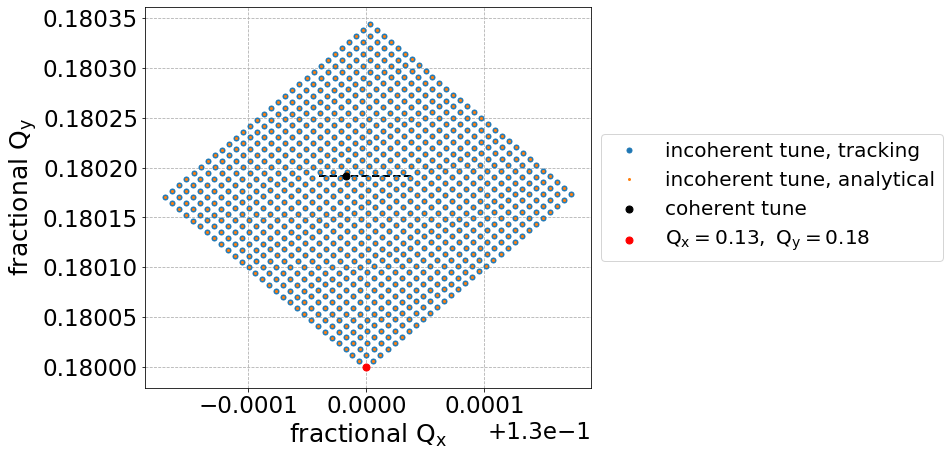

In [41]:
my_scale = 1

fig, ax = plt.subplots() 

ax.plot(np.array(Qx_incoherent_tracking)*my_scale, np.array(Qy_incoherent_tracking)*my_scale, '.', ms=10, label='incoherent tune, tracking')
ax.plot(0.13*my_scale+np.array(Qx_incoherent_analytical)*my_scale, 0.18*my_scale+np.array(Qy_incoherent_analytical)*my_scale, '.', ms=4, label='incoherent tune, analytical')

#plt.ticklabel_format(axis="both", style="sci", scilimits=(1,1))
ax.hlines(Qy_coherent*my_scale, 0.12996*my_scale, 0.13004*my_scale, ls='--')#, zorder=50, label=' vertical coherent tune')
#ax.vlines(Qx_coherent, 0, 1)
ax.scatter(Qx_coherent, Qy_coherent, c='k', label='coherent tune', zorder=50)
ax.scatter(0.13*my_scale, 0.18*my_scale, c='r', zorder=50, label=r'$\mathrm{Q_x=0.13, \ Q_y=0.18}$')
ax.grid(linestyle='dashed')

ax.set_xlabel('fractional '+r'$\mathrm{Q_x}$')
ax.set_ylabel('fractional '+r'$\mathrm{Q_y}$')

#ax.set_xlim(0.12996*my_scale, 0.13004*my_scale)
#ax.set_ylim(0.17997, 0.18001)
#ax.legend(loc=3)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
savefig = False

if savefig:
    plt.savefig('SPS_AmplitudeDetuning_Coherent_incoherent_chroma5e-1_noAmplDetuning.png', bbox_inches='tight')

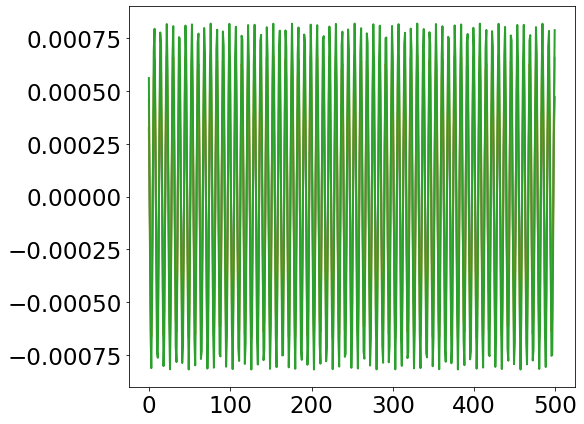

In [43]:
for particle in np.arange(5,20, 5):
    x_signal = []
    y_signal = []
    for turn in range(n_turns):
        x_signal.append(X[f'turn {turn}'][particle])
        y_signal.append(Y[f'turn {turn}'][particle])

    plt.plot(x_signal)
    #plt.plot(y_signal)
   